In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
from datetime import datetime

In [2]:
df_full = pd.read_pickle("./data_frame_full_2021-03-12.pickle")

In [3]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209222 entries, 0 to 209221
Columns: 107 entries, backers_count to deadline_month
dtypes: bool(5), datetime64[ns](3), float64(18), int64(16), object(65)
memory usage: 163.8+ MB


In [4]:
df_small = pd.read_pickle("./data_frame_small_2021-03-12.pickle")

In [5]:
df_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209222 entries, 0 to 209221
Data columns (total 33 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   blurb                  209214 non-null  object        
 1   country                209222 non-null  object        
 2   created_at             209222 non-null  int64         
 3   currency               209222 non-null  object        
 4   deadline               209222 non-null  int64         
 5   disable_communication  209222 non-null  bool          
 6   goal                   209222 non-null  float64       
 7   launched_at            209222 non-null  int64         
 8   name                   209222 non-null  object        
 9   staff_pick             209222 non-null  bool          
 10  state                  209222 non-null  object        
 11  usd_pledged            209222 non-null  float64       
 12  usd_type               208742 non-null  obje

# Target classes and balance

In [6]:
vals = df_full['state'].value_counts()
vals

successful    117465
failed         75199
canceled        8624
live            7311
suspended        623
Name: state, dtype: int64

In [7]:
print('Portion of success: {:.2f}%'.format( 100*vals[0] / (vals[0]+vals[1]) ))
print('Portion of fail:    {:.2f}%'.format( 100*vals[1] / (vals[0]+vals[1]) ))

Portion of success: 60.97%
Portion of fail:    39.03%


We have a sligth imbalance.

# Date time

In [8]:
df_full['launched_at'].describe(datetime_is_numeric=True)

count    2.092220e+05
mean     1.460206e+09
std      6.309029e+07
min      1.240603e+09
25%      1.417639e+09
50%      1.461924e+09
75%      1.516694e+09
max      1.552537e+09
Name: launched_at, dtype: float64

## Country

In [9]:
ratio = lambda x: 100*round(x.value_counts()['successful'] / (x.value_counts()['successful'] + x.value_counts()['failed'] + x.value_counts()['canceled']), 4)

In [10]:
success_per_country = pd.pivot_table(df_full, index='country', values='state', aggfunc=ratio).rename(columns={'state':'success_ratio'}).sort_values(by='success_ratio', ascending=False)
success_per_country

,success_ratio
country,
HK,76.70
JP,73.19
LU,66.07
SG,64.20
GB,62.69
US,59.49
DK,57.76
NZ,55.53
CA,55.10


<AxesSubplot:xlabel='success_ratio', ylabel='country'>

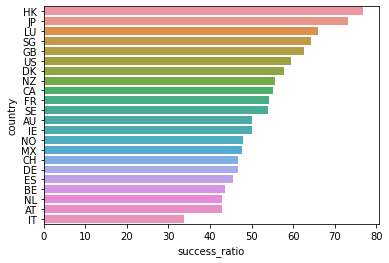

In [11]:
sns.barplot(data=success_per_country.reset_index(), y='country', x='success_ratio')

# Pledged

## Pledged amount - Exchange rate

In [12]:
currency_delta = df_full['converted_pledged_amount'].astype(float) - df_full['usd_pledged'] * df_full['static_usd_rate']
currency_delta.describe()

count    2.092220e+05
mean    -8.551623e+01
std      1.270609e+04
min     -1.771501e+06
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.330207e+05
dtype: float64

In [13]:
currency_cols = ['country', 'converted_pledged_amount', 'currency', 'currency_symbol', 'fx_rate', 'usd_pledged', 'usd_type']
df_full[currency_delta > 900][currency_cols].head(10)

,country,converted_pledged_amount,currency,currency_symbol,fx_rate,usd_pledged,usd_type
56,SG,19699,SGD,$,0.737115,19338.586040,international
83,NO,2182,NOK,kr,0.115720,2088.859902,domestic
87,SE,4340,SEK,kr,0.106663,4417.467480,domestic
94,NO,4649,NOK,kr,0.115720,4967.397210,international
113,SE,62874,SEK,kr,0.106663,63854.911570,domestic
145,MX,2107,MXN,$,0.051662,2112.931235,international
154,SE,5571,SEK,kr,0.106663,5507.784406,international
165,MX,2061,MXN,$,0.051662,2051.492031,domestic
275,CA,41677,CAD,$,0.748258,41786.790700,domestic
300,SG,12189,SGD,$,0.737115,12090.014060,domestic


## Plegded - over the years

In [14]:
pledged_per_year = pd.pivot_table(df_full, index=['launched_at_year', 'launched_at_month'], values='pledged', aggfunc=len).rename(columns={'pledged':'pledged'})
pledged_per_year

pledged
launched_at_year launched_at_month         
2009             4                      6.0
                 5                     12.0
                 6                      5.0
                 7                     12.0
                 8                     16.0
...                                     ...
2018             11                  3843.0
                 12                  2192.0
2019             1                   3850.0
                 2                   5032.0
                 3                   3296.0

[120 rows x 1 columns]

In [15]:
pledged_median_per_year = pd.pivot_table(df_full, index='launched_at_year', values='pledged', aggfunc=pd.Series.median).rename(columns={'pledged':'pledged_median'})
pledged_median_per_year

,pledged_median
launched_at_year,
2009,2005.500
2010,2177.000
2011,2260.000
2012,2596.000
2013,3185.000
2014,1010.000
2015,551.500
2016,1014.500
2017,1307.175


In [16]:
pledged_mean_per_year = pd.pivot_table(df_full, index='launched_at_year', values='pledged', aggfunc=pd.Series.mean).rename(columns={'pledged':'pledged_mean'})


<AxesSubplot:xlabel='launched_at_year', ylabel='pledged_median'>

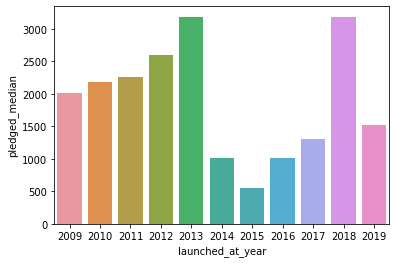

In [17]:
sns.barplot(data=pledged_median_per_year.reset_index(), x='launched_at_year', y='pledged_median')

<AxesSubplot:xlabel='launched_at_year', ylabel='pledged_mean'>

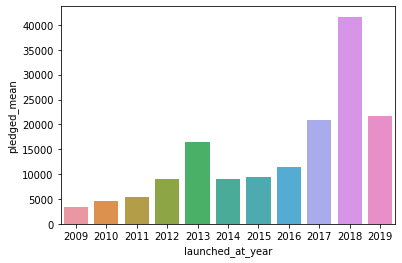

In [18]:
sns.barplot(data=pledged_mean_per_year.reset_index(), x='launched_at_year', y='pledged_mean')